In [1]:
import sys 
import numpy as np
import settings as s
import matplotlib.pyplot as plt 
import importlib
importlib.reload(s)
from cupyx.profiler import benchmark
import h5py
import os
import re
import time
import datetime
from datetime import datetime

sys.path.insert(0, '../../../../drlib')
import drlib as dr
%matplotlib widget

def mad_np(arr):
    median = np.median(arr)
    return np.median(np.abs(arr-median))

def freq2Idx(freq, freqsAll):
    return int(freq/freqsAll[-1] * len(freqsAll))

def idx2Freq(idx, freqs):
    return  ((freqs[-1] - freqs[0])/len(freqs) * idx) + freqs[0]

dataDir         = '/drBiggerBoy/termTest_3_29_23/'

totalAcqs       = int(open(s.SAVE_DIRECTORY + 'database.txt', 'r'
                    ).readlines()[-1].split(',')[0].strip()) + 1 

print(totalAcqs)
    





120


diff mean:              254.20471759663866
diff median:            254.204501
diff STD:               0.001636575212306325
diff percent error:     0.0006438020614956382
expected single time:   6.355006060606061
total time:             30250.361394
expected total time:    30504.029090909095


Text(0, 0.5, 'Time Delta (Seconds)')

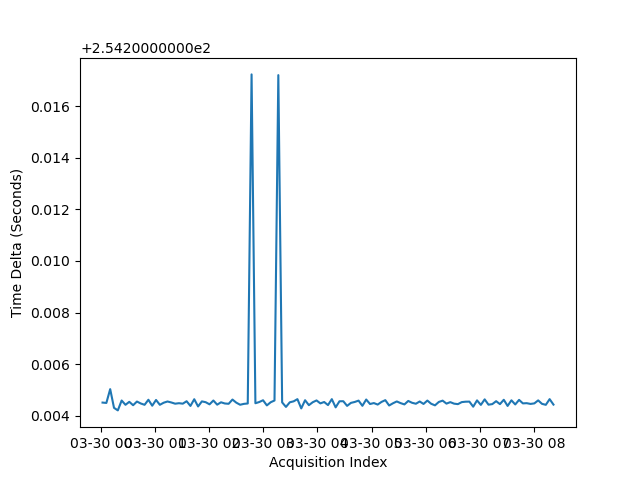

In [2]:
#time delta analysis
datetimes_str = np.loadtxt(f'{dataDir}database.txt',
                        skiprows=1,
                        usecols=1,
                        delimiter=',',
                        dtype=str)
datetimes =[]
for date in datetimes_str:
    data = date[10]
    datetimes.append(datetime.strptime(date, ' %Y-%m-%d %H:%M:%S.%f'))


diff = []
for i in range(len(datetimes)-1):
    diff.append((datetimes[i+1] - datetimes[i]).total_seconds())

print(f"diff mean:              {np.mean(diff)}")
print(f"diff median:            {np.median(diff)}")
print(f"diff STD:               {np.std(diff)}")
print(f"diff percent error:     {np.std(diff)/np.mean(diff) * 100}")
print(f"expected single time:   {2**24/s.SAMPLE_RATE * 250}")
print(f"total time:             {(datetimes[-1] - datetimes[0]).total_seconds()}")
print(f"expected total time:    {2**24/s.SAMPLE_RATE * s.NOF_BUFFERS_TO_RECEIVE * s.NOF_ACQUISITIONS_TO_TAKE}")

plt.close('all')
plt.figure()
plt.plot(datetimes[1:], diff)
plt.xlabel('Acquisition Index')
plt.ylabel('Time Delta (Seconds)')

In [5]:
#pack pre proc dataset

try:
    f.close()
    print("closed")
except:
    print("didn't close")
    pass

rawDataDir      = dataDir + 'data/'
fileList        = os.listdir(rawDataDir)
fileList.sort(key=lambda f: int(re.sub('\D', '', f)))
newDataDir      = dataDir
fileName        = 'packedh5.hdf5'
if 0: #will overwrite!!!

    f               = h5py.File(newDataDir + fileName, 'w')

    #init empty dataset
    print(f'initilizing dataset 8388609x{totalAcqs}')
    spec_W    = f.create_dataset('spec_W_chB', (8388609, totalAcqs), chunks = (2**16,2**0), dtype = 'f')
    print(spec_W)

    ##############################################################
    #Main loop
    ##############################################################
    numFiles        = 0
    numMeasData     = 0
    numRigolSpec    = 0

    compType = False
    chunks = None #must add chunks arg to create dataset calls

    for fileidx, file in enumerate(fileList):
        if fileidx % 10 == 0:
            print(file)
        dataset         = h5py.File(rawDataDir +  file, 'r')
        numFiles        += 1
        measDataKeys    = list(dataset.keys())
        measDataKeys.sort(key=lambda f: int(re.sub('\D', '', f)))
        #measDataKeys = [int(key) for key in measDataKeys]

        for measData in measDataKeys:
            measDataInt = int(measData)
            '''Dumb check. Is the date in raw h5 measData the same as what
            the database thinks it is? Since we previously check that dates
            are consectutive this also checks that dates 
            in raw h5 are consecutive'''
            '''datasetDf   = pd.read_hdf(rawDataDir + file, key = measData)#raw H5 
            dateTimeStr = datasetDf.columns[0][0]#datetime extracted from raw H5
            dateTime    = datetime.strptime(dateTimeStr, '%Y-%m-%d %H:%M:%S.%f')'''

            '''Check database at a measData has the same datetime as we are about
            to load into new h5'''
            '''if not (dateTime==database[database['measData'] == measDataInt].index):
                print('Dates got jumbled at measData', measDataInt)'''

            spec_W_np        = np.float32(dataset[measData]['chBSpec_W'])
            #print(measData)
            #termSpec    = np.float32(dr.fft2Watts(datasetDf.iloc[:,0][:]))
            #diffSpec    = np.float32((antSpec-termSpec))

            spec_W[:, measDataInt]    = spec_W_np

f.close()

didn't close
initilizing dataset 8388609x120
<HDF5 dataset "spec_W_chB": shape (8388609, 120), type "<f4">
0.hdf5


In [3]:
#Average and save spectra

#location of packed h5
fileName        = 'packedh5.hdf5'


f               = h5py.File(dataDir + fileName, 'r')

def avgSpecFromPacked(avgIdxs):
    sum = np.zeros(2**23+1)
    for i in avgIdxs:
        sum += f['spec_W_chB'][:,i]
    avgSpec = sum/(len(avgIdxs))
    return avgSpec

def rollingMadLim(spec,
    nSigma = 5,
    order = 1,
    fc_numBins = 100
):
    specFiltered = dr.filterSpec(spec, fc_numBins=fc_numBins, order=order)
    window = 1000

    rollingMadArr = dr.rolling(specFiltered, window, 1, mad_np, numProc=48)

    filter_fc           = 30 * window
    filteredMadArr  = dr.filterSpec(rollingMadArr, order = 2, fc_numBins = filter_fc, type = 'lowpass')
    diffFilterMadPadArr = dr.nanPad(filteredMadArr, window)
    rollMadLim      = diffFilterMadPadArr * nSigma * 1.48
    return rollMadLim, specFiltered, nSigma, order, fc_numBins

#Average and save
if 0:
    antIdxs     = range(6, totalAcqs-1, 2)[0:-1]
    termIdxs    = range(7, totalAcqs-1, 2)
    avgAntSpec  = avgSpecFromPacked(antIdxs)
    avgtermSpec = avgSpecFromPacked(termIdxs)

    np.save('./avgSpecs_gitignore/avgAntSpec_W_296Avgs_3_23_23', avgAntSpec)
    np.save('./avgSpecs_gitignore/avgTermSpec_W_296Avgs_3_23_23', avgtermSpec)
    print('Done saving raw spectra')

    #filter/rolling mad limit and save
    antRollingMadLim, antFilt, Sigma, order, fc_numBins     = rollingMadLim(avgAntSpec)
    termRollingMadLim, termFilt, nSigma, order, fc_numBins   = rollingMadLim(avgtermSpec)

    np.save(f'./avgSpecs_gitignore/antRollingMadLim_W_296Avgs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_23_23', antRollingMadLim)
    np.save(f'./avgSpecs_gitignore/termRollingMadLim_W_296Avgs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_23_23', termRollingMadLim)
    np.save(f'./avgSpecs_gitignore/antFilt_W_296Avgs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_23_23', antFilt)
    np.save(f'./avgSpecs_gitignore/termFilt_W_296Avgs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_23_23', termFilt)

    f.close()

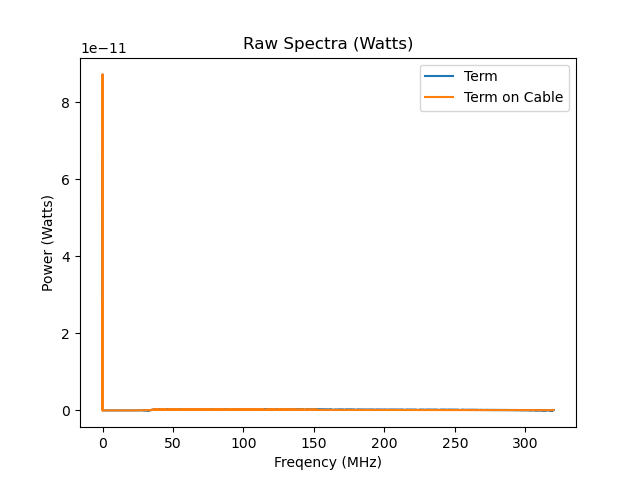

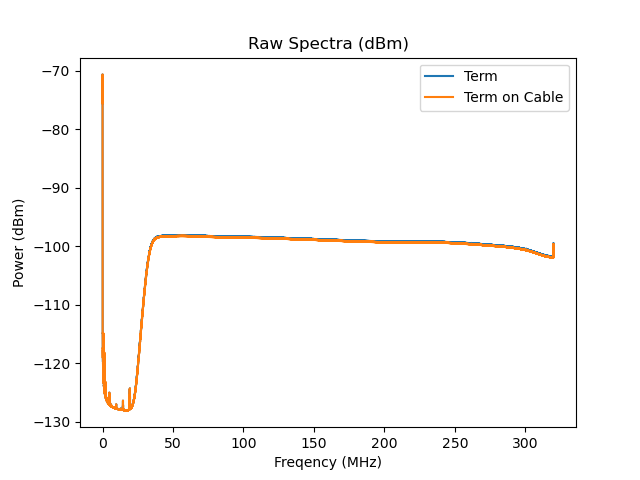

In [5]:
#load files generated in previous cell
nSigma      = 5
order       = 1
fc_numBins  = 100

avgAntSpec          = np.load('./avgSpecs_gitignore/avgAntSpec_W_296Avgs_3_23_23.npy', allow_pickle=True)
avgTermSpec         = np.load('./avgSpecs_gitignore/avgTermSpec_W_296Avgs_3_23_23.npy', allow_pickle=True)
filtAntSpec         = np.load(f'./avgSpecs_gitignore/antFilt_W_296Avgs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_23_23.npy', 
    allow_pickle=True
)
filtTermSpec        = np.load(f'./avgSpecs_gitignore/termFilt_W_296Avgs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_23_23.npy', 
    allow_pickle=True
)
termRollingMadLim   = np.load(f'./avgSpecs_gitignore/termRollingMadLim_W_296Avgs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_23_23.npy',
    allow_pickle=True
)
antRollingMadLim   = np.load(f'./avgSpecs_gitignore/antRollingMadLim_W_296Avgs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_23_23.npy',
    allow_pickle=True
)

#plot raw spectra
freqs       = np.linspace(0, 320, 2**23)

plt.close('all')

plt.title('Raw Spectra (Watts)')
plt.plot(freqs, avgTermSpec[1:], label = 'Term')
plt.plot(freqs, avgAntSpec[1:], label = 'Term on Cable')
plt.ylabel('Power (Watts)')
plt.xlabel('Freqency (MHz)')
plt.legend(loc = 'upper right')

plt.figure()
plt.title('Raw Spectra (dBm)')
plt.plot(freqs, 10*np.log10(avgTermSpec[1:]*1000), label = 'Term')
plt.plot(freqs, 10*np.log10(avgAntSpec[1:]*1000), label = 'Term on Cable')
plt.ylabel('Power (dBm)')
plt.xlabel('Freqency (MHz)')
plt.legend(loc = 'upper right')


18 antenna candidates
23 term candidates


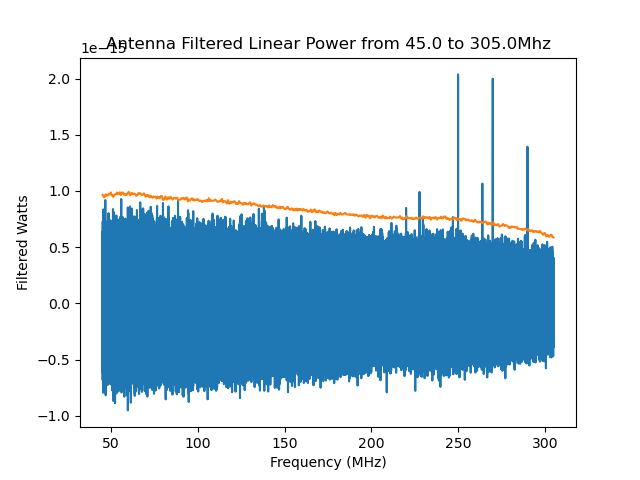

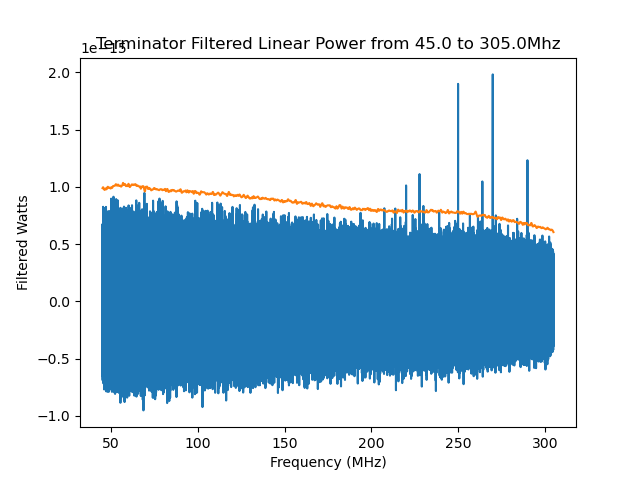

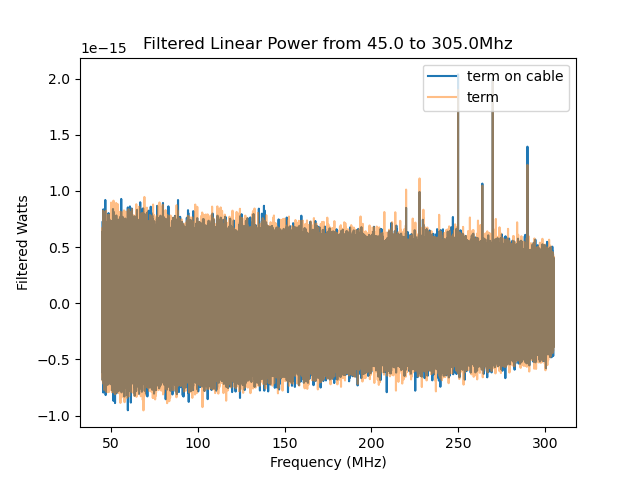

In [8]:
pltFreqStart = 45e6
pltFreqStop = 305e6
freqs=np.linspace(0,s.SAMPLE_RATE/2, 2**23)
pltIdxStart = freq2Idx(pltFreqStart, freqs)
pltIdxStop = freq2Idx(pltFreqStop, freqs)

antCanList_idx = ((filtAntSpec > antRollingMadLim)) 
antCandidateTotal = (antCanList_idx[pltIdxStart:pltIdxStop].sum())
print(f"{antCandidateTotal} antenna candidates")

termCanList_idx = ((filtTermSpec > termRollingMadLim)) 
termCandidateTotal = (termCanList_idx[pltIdxStart:pltIdxStop].sum())
print(f"{termCandidateTotal} term candidates")


plt.close('all')

plt.figure()
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, filtAntSpec[pltIdxStart:pltIdxStop])
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6,(antRollingMadLim)[pltIdxStart:pltIdxStop])
plt.text(200,.75e-14, f'{antCandidateTotal} candidates',size=16)
plt.title(f"Antenna Filtered Linear Power from {pltFreqStart/1e6} to {pltFreqStop/1e6}Mhz")
plt.xlabel('Frequency (MHz)')
plt.ylabel('Filtered Watts')

plt.figure()
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, filtTermSpec[pltIdxStart:pltIdxStop])
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6,(termRollingMadLim)[pltIdxStart:pltIdxStop])
plt.text(200,.75e-14, f'{termCandidateTotal} candidates',size=16)
plt.title(f"Terminator Filtered Linear Power from {pltFreqStart/1e6} to {pltFreqStop/1e6}Mhz")
plt.xlabel('Frequency (MHz)')
plt.ylabel('Filtered Watts')

plt.figure()
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, filtAntSpec[pltIdxStart:pltIdxStop], label = 'term on cable')
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, filtTermSpec[pltIdxStart:pltIdxStop], label = 'term', alpha = .5)
plt.text(200,.75e-14, f'{termCandidateTotal} candidates',size=16)
plt.title(f"Filtered Linear Power from {pltFreqStart/1e6} to {pltFreqStop/1e6}Mhz")
plt.xlabel('Frequency (MHz)')
plt.ylabel('Filtered Watts')
plt.legend(loc = 'upper right')

In [45]:

antCanIdx = (np.where(antCanList_idx[pltIdxStart:pltIdxStop] ==True))
termCanIdx = (np.where(termCanList_idx[pltIdxStart:pltIdxStop] ==True))



antCandidateFreqs = np.asarray([freqs[x] for x in antCanIdx])
termCandidateFreqs = np.asarray([freqs[x] for x in termCanIdx])

print(len(antCanIdx[0]))
print(antCandidateFreqs/1e6)
print(len(termCanIdx[0]))
print(termCandidateFreqs/1e6)

18
[[ 43.52163953  93.07651556 175.02499163 175.02503097 175.02510965
  175.02522767 175.02526701 182.78973732 202.02319885 204.99951422
  205.00045836 219.00001395 224.99953687 225.00048101 244.99952018
  244.99955952 245.00046432 245.00050366]]
23
[[162.48487621 168.79187331 175.02503097 175.02507031 175.02510965
  175.02514899 175.02518833 175.02534569 175.02538503 182.78973732
  184.99949157 194.09684826 204.99951422 205.00045836 211.82944558
  219.00001395 224.99953687 225.00048101 226.7837604  239.05499328
  244.99952018 244.99955952 245.00050366]]
